Cost after epoch 0: 0.741449
Cost after epoch 1000: 0.414667
Cost after epoch 2000: 0.391278
Cost after epoch 3000: 0.375256
Cost after epoch 4000: 0.365144
Cost after epoch 5000: 0.355424
Cost after epoch 6000: 0.348095
Cost after epoch 7000: 0.343559
Cost after epoch 8000: 0.339508
Cost after epoch 9000: 0.335915
Cost after epoch 10000: 0.332863
Cost after epoch 11000: 0.329908
Cost after epoch 12000: 0.327031
Cost after epoch 13000: 0.324313
Cost after epoch 14000: 0.321646
Cost after epoch 15000: 0.319453
Cost after epoch 16000: 0.317153
Cost after epoch 17000: 0.314978
Cost after epoch 18000: 0.312823
Cost after epoch 19000: 0.311135


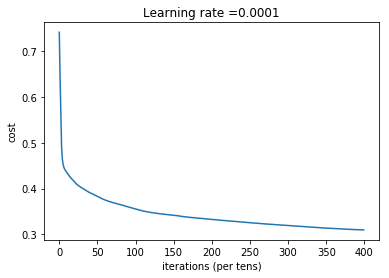

Parameters have been trained!
Train Accuracy: 0.8764045
Test Accuracy: 0.82222223


In [14]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

import numpy as np
import pandas as pd
from pandas import Series

# Input data
df_train = pd.read_csv('./input/train.csv')
df_test = pd.read_csv('./input/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

# Fare
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].median()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

def category_fare(x):
    if x == 0:
        return 0
    elif x < 2:
        return 1
    elif x < 3:
        return 2
    elif x < 4:
        return 3    
    else:
        return 4
    
df_train['Fare_cat'] = df_train['Fare'].apply(category_fare)
df_test['Fare_cat'] = df_test['Fare'].apply(category_fare)

# Name
df_train['Initial']= df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial']= df_test.Name.str.extract('([A-Za-z]+)\.')

df_train['Initial'].replace(['Master', 'Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Other', 'Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)
df_test['Initial'].replace(['Master', 'Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Other', 'Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

# Age
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = np.round(df_train.groupby("Initial").mean()["Age"]["Mr"])
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = np.round(df_train.groupby("Initial").mean()["Age"]["Mrs"])
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = np.round(df_train.groupby("Initial").mean()["Age"]["Miss"])
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = np.round(df_train.groupby("Initial").mean()["Age"]["Other"])

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = np.round(df_test.groupby("Initial").mean()["Age"]["Mr"])
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = np.round(df_test.groupby("Initial").mean()["Age"]["Mrs"])
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = np.round(df_test.groupby("Initial").mean()["Age"]["Miss"])
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = np.round(df_test.groupby("Initial").mean()["Age"]["Other"])

def category_age(x):
    if x < 18:
        return 0
    elif x < 27:
        return 1
    elif x < 36:
        return 2
    elif x < 45:
        return 3
    elif x < 54:
        return 4
    else:
        return 5
    
df_train['Age_cat'] = df_train['Age'].apply(category_age)
df_test['Age_cat'] = df_test['Age'].apply(category_age)

# Initial
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

# Embarked
df_train['Embarked'].fillna('S', inplace=True)

df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

# Sex
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

# Cabin_cat
df_train['Cabin_cat'] = df_train.Cabin.isnull()
df_train['Cabin_cat'] = df_train['Cabin_cat'].map({True:0, False:1})
df_test['Cabin_cat'] = df_test.Cabin.isnull()
df_test['Cabin_cat'] = df_test['Cabin_cat'].map({True:0, False:1})

### One-hot enconding
df_train = pd.get_dummies(df_train, columns=['Fare_cat'], prefix='Fare_cat')
df_test = pd.get_dummies(df_test, columns=['Fare_cat'], prefix='Fare_cat')
df_train = pd.get_dummies(df_train, columns=['Age_cat'], prefix='Age_cat')
df_test = pd.get_dummies(df_test, columns=['Age_cat'], prefix='Age_cat')
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

### Drop
df_train.drop(['PassengerId', 'Name', 'Fare', 'Age',  'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'Fare', 'Age', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

X_train_orig = df_train.drop('Survived', axis= 1).values
temp_1 = df_train['Survived'].values
temp_2 = pd.get_dummies(temp_1, columns=['Survived'], prefix='Survived')
Y_train_orig = temp_2.values
cut = int(np.floor(len(Y_train_orig)*0.9))
X_train = X_train_orig[:cut]
Y_train = Y_train_orig[:cut]
X_valid = X_train_orig[cut:]
Y_valid = Y_train_orig[cut:]
X_test = df_test.values

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    #np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    #permutation = list(np.random.permutation(m))
    #shuffled_X = X[permutation, :]
    #shuffled_Y = Y[permutation, :].reshape((m, Y.shape[0]))
    shuffled_X = X
    shuffled_Y = Y

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(dtype= tf.float32, shape= [None, n_x])
    Y = tf.placeholder(dtype= tf.float32, shape= [None, n_y])
    
    return X, Y

def initialize_parameters(n_x, n_y):
    """
    Initializes parameters to build a neural network with tensorflow. 
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours

    W1 = tf.get_variable(name= "W1", shape= [n_x, 12], initializer= tf.contrib.layers.xavier_initializer(seed= 1))
    b1 = tf.get_variable(name= "b1", shape= [12], initializer= tf.zeros_initializer())
    W2 = tf.get_variable(name= "W2", shape= [12, 4], initializer= tf.contrib.layers.xavier_initializer(seed= 1))
    b2 = tf.get_variable(name= "b2", shape= [4], initializer= tf.zeros_initializer())
    W3 = tf.get_variable(name= "W3", shape= [4, n_y], initializer= tf.contrib.layers.xavier_initializer(seed= 1))
    b3 = tf.get_variable(name= "b3", shape= [n_y], initializer= tf.zeros_initializer())


    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(X, W1), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(A1, W2), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(A2, W3), b3)                     # Z3 = np.dot(W3,Z2) + b3

    return Z3

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    #logits = tf.transpose(Z3)
    #labels = tf.transpose(Y)
    logits = Z3
    labels = Y
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits= logits, labels= labels))

    return cost

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 20000, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 1                                          # to keep consistent results
    (m, n_x) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    _, n_y = Y_train.shape                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###    

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters(n_x, n_y)
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 1000 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 50 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3, axis=1), tf.argmax(Y, axis=1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", sess.run(accuracy, feed_dict = {X: X_train, Y: Y_train}))
        print ("Test Accuracy:", sess.run(accuracy, feed_dict = {X: X_test, Y: Y_test}))
     
    return parameters

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(X, W1), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(A1, W2), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(A2, W3), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [None, X.shape[1]])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3, axis=1)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

parameters = model(X_train, Y_train, X_valid, Y_valid)

In [11]:
submission = pd.read_csv('./input/sample_submission.csv')
prediction = predict(X_test, parameters)

In [12]:
submission['Survived'] = prediction
submission.to_csv('./output/sample_submission_L3.csv', index= False)